# QAOA を利用して、組合せ最適化問題を解く

このセクションでは、組合せ最適化問題を紹介し、近似最適化アルゴリズムの説明、Quantum Approximate Optimization Algorithm (QAOA)の動作説明、及びシミュレーターもしくは5量子ビットチップで動作する実装例の紹介をします。

## 目次
1. [はじめに](#introduction)
2. [様々な例](#examples)
3. [近似最適化アルゴリズム](#approximateOPT)
4. [QAOA](#QAOA)
5. [Qiskit での実装](#implementation)
    - 5a [QAOAをシミュレーターで動かす](#implementationsim)
    - 5b [QAOAを実量子デバイスで動かす](#implementationdev)
6. [演習問題](#problems)
7. [参考文献](#references)

## 1. はじめに <a id='introduction'></a>

組合せ最適化[1](#references) とは、有限または可算無限集合の解の中から最適解を探し出す方法を意味します。最小化もしくは最大化する関数を基準として最適性は定義されて、その関数は通常コスト関数や目的関数と呼ばれます。

様々なタイプの組合せ最適化問題があります。例えば最小化では、コスト、距離、移動の長さ、重さ、処理時間、物質とエネルギー消費、物の数を扱います。最大化では、利益、価値、アウトプット、リターン、利回り、ユーティリティー、効率、容量、物の数などです。どのような最大化問題も、最小化問題に変換できる（その逆も真）ので、組合せ最適化問題は一般的に次の形式で与えることができます。


$$ \text{maximize } \;\;      C(x)$$

$$ \text{subject to } \;\; x \in S $$


ここで、$x \in S$ は離散変数で、$C : D \rightarrow \mathbb{R}$ はコスト関数です。これは、ある定義域 $S$ からの実数 $\mathbb{R}$ への写像です。変数 $x$ は複数の制約を受け、実行可能解は $S \subset D$ 集合内に存在します。

0-1変数のみの組合せ最適化問題では、典型的なコスト関数は、$n$ビットのバイナリ文字列 $x \in \{0,1\}^n$ の部分集合 $Q \subset[n]$ を含む項の和で表されます。そのようなコスト関数 $C$ は、以下の形式で記述されます。


$$ C(x) = \sum_{(Q,\overline{Q}) \subset [n]} w_{(Q,\overline{Q})} \; \prod_{i\in Q} x_i \; \prod_{j\in \overline{Q}} (1- x_j), $$


ここで、$x_i \in \{0,1\}$、及び $w_{(Q,\overline{Q})}\in \mathbb{R}$ です。我々の目的は、$C(x)$ が最大になる、$n$ビット文字列 $x$ を探すことです。

### 1.1 対角ハミルトニアン

コスト関数は、計算基底において対角なハミルトニアンにマッピングすることが出来ます。コスト関数 $C$ が与えられると、ハミルトニアンは次のように記述できます:


$$ H = \sum_{x \in \{0,1\}^n} C(x) |x \rangle\langle x| $$

ここで$x \in \{0,1\}^n$ は、計算基底 $|x \rangle \in \mathbb{C}^{2^n}$ でのラベルです。仮にコスト関数が高々$k$個の重み付き項しかない場合、つまり $Q$ が高々 $Q \leq k$ ビットしか含まない時には、この対角ハミルトニアンは、$k$ 個の重み付きパウリ $Z$ 演算子の和になります。

$H$ のパウリ $Z$ 演算子への展開は、コスト関数 $C$ の正規展開において、全てのバイナリ変数 $x_i \in \{0,1\}$ を 行列 $x_i \rightarrow 2^{-1}(1 - Z_i)$ に置き換えることで得られます。ここで、$Z_i$ は量子ビット $i$ に作用し、その他には自明なパウリ $Z$ 演算子、すなわち次の通りです。

$$ Z_i = \left(\begin{array}{cc} 1 & 0 \\ 0 & -1 \end{array}\right). $$

これは、古典コスト関数をエンコードするスピン-ハミルトニアンが $|Q|$ と記述され、ローカル量子スピンハミルトニアンがパウリ $Z$ 演算子しか含まないことになります。


$$ H = \sum_{(Q,\overline{Q}) \subset [n]} w_{(Q,\overline{Q})} \; \frac{1}{2^{|Q| + |\overline{Q}|}}\prod_{i\in Q} \left(1 - Z_i\right) \; \prod_{j\in \overline{Q}} \left(1 + Z_j\right).$$

ここで、数少ない($n$の多項式) $w_{(Q,\overline{Q})}$ のみが非ゼロであると想定します。また、集合 $|(Q,\overline{Q})|$ は有界であり、大きくないと想定します。これは、コスト関数とハミルトニアン $H$ を $m$ 個のローカル項 $\hat{C}_k$ の和として書けることを意味します。


$$ H = \sum_{k = 1}^m \hat{C}_k, $$

ここで、$m$ と $\hat{C}_k$ の台は妥当性のある有界値です。

## 2 様々な例 <a id='examples'></a>

ここでは組合せ最適化問題を2つ例示します。最初の例のみQiskitで実装しますが、演習問題を通じて2番目の例の実装方法を示します。

### 2.1 (重みつき) MAXCUT

$n$個の頂点と$m$本の枝を含む無向グラフ $G = (V, E)$ を考えます。枝 $(j,k)\in E$ の重みを $w_{ij} \geq 0$, $w_{ij}=w_{ji}$とします。カットは、頂点集合 $V$ を2つの部分集合 $S, T \subset V$ への分割として定義します $(S \cap T = \emptyset, S \cup T = V)$。2つの部分集合$S$と$T$の間を結ぶ(横切る)枝の重みの合計 $\sum_{s \in S, t \in T} w_{st}$ をコスト関数とします。各頂点 $i$ に対して、0-1変数$x_i$を割り当て、$x_i = 0$のとき$i \in S$、 $x_i = 1$のとき$i \in T$を意味します。（ここでは$n$個の頂点に対応する変数$x_i$が $0,1,\dots,n-1$ のインデックスをとります）。MAXCUTは以下のコスト関数を最大化します。 


$$C(\textbf{x}) = \sum_{i,j = 1}^n w_{ij} x_i (1-x_j).$$

表記を簡単にするために、以下では均一の重み $ w_{ij} = 1$ を仮定します。量子コンピューター上でこの問題の最適解を見つけるためには、上記で説明したように、これを対角ハミルトニアンにマッピングする必要があります。集合 $(i,j) = E$ の枝の総和を以下のように記述します。



$$C(\textbf{x}) = \sum_{i,j = 1}^n w_{ij} x_i (1-x_j)  = \sum_{(i,j) \in E} \left( x_i (1-x_j) + x_j (1-x_i)\right)$$

これをスピンハミルトニアンにマップするために、$x_i\rightarrow (1-Z_i)/2$ の変換を行います。ここで、$Z_i$ は固有値 $\pm 1$ をもつパウリ$Z$演算子で、$X \rightarrow H$ を得ます。



$$ H = \sum_{(j,k) \in E} \frac{1}{2}\left(1 - Z_j Z_k \right).$$

この式が意味することは、ハミルトニアンはローカル項 $\hat{C}_e = \frac{1}{2}\left(1 - Z_{j}Z_{k}\right)$ ($e = (j,k) \in E$) の $m = |E|$ 個の和として記述できるということです。

### 2.2 制約充足問題とMAX-3-SAT

組合せ最適化問題の別の例として、3-SAT があります。$n$個の0-1変数$\textbf{x} \in \{0,1\}^n$ のうち3つを含む$m$個の節 $c_k(\textbf{x})$ を全て充足する($c_k(\textbf{x})=1$になる)ようなビット文字列があるかどうかを判定する決定問題です。3-SATはNP完全な問題の主要な例になっています。
あるビット文字列 $\textbf{x} \in \{0,1\}^{133}$ に対して、以下で 3-SATの節の例を考えてみます。

$$ c_1(\textbf{x}) = (1-x_1)(1-x_3)x_{132} $$

この節$c_1(\textbf{x})$は、$x_1 = 0$、$x_3 = 0$ 及び $x_{132} = 1$ の時のみ充足します。

3-SATと密接に関連している問題にMAX-3-SATがあります。この問題は充足する節の数$C(\textbf{x}) = \sum_{k = 1}^m c_k(\textbf{x})$を最大化する問題で、NP困難です。この問題は最適化問題ですが、充足する節の数が閾値を超えるかどうか考えることで決定問題に変換することもできます。

## 3. 近似アルゴリズム<a id='approximateOPT'></a>

これまでに紹介したMAXCUTとMAX-3-SATの両者はNP困難として知られています [1](#references)。実は、一般的に組合せ最適化問題の多くは、厳密な最適解を求めることが計算上困難です。この事実に照らし合わせてみると、効率的なアルゴリズム、つまり問題のサイズに対して多項式時間でこれらの問題を解くアルゴリズムを見つけることは期待できません。これは量子アルゴリズムにも当てはまります。このような問題を扱うには、主に2つのアプローチがあります。1つ目のアプローチは、多項式時間内に指定された品質の解を見つけることが保証されている近似アルゴリズムです。2つ目のアプローチは、多項式の実行時間は保証されていないが、一部の問題例で良好なパフォーマンスを発揮するヒューリスティックなアルゴリズムです。

近似アルゴリズムは$NP$困難な最適化問題に対して効率的に近似解を求め、近似解が最適解にどの程度近いかの理論保証を与えます。保証は典型的には、近似比 $\alpha \leq 0$ で示されます。確率的近似アルゴリズムの場合、 *高い確率で* 正の $C_{max} = \max_{\textbf{x}}C(\textbf{x})$ をもつビット文字列 $\textbf{x}^* \in \{0,1\}^n$ が生成されます。

$$ C_{max} \geq C(\textbf{x}^*) \geq \alpha C_{max}. $$

MAXCUT問題に関しては、Goemans と Williamson [2](#references) による有名な近似アルゴリズムがあります。このアルゴリズムは元の問題のSDP緩和と確率的丸めのテクニックを組み合わせて、$\alpha \approx 0.878$ という近似比の近似解を高い確率で出力します。
この近似比は量子アルゴリズムをもってしても改善することができない最適な値と考えられています。

## 4. QAOA <a id="QAOA"></a>
Farhi、Goldsone、Gutmann [3](#references) による量子近似最適化アルゴリズム（Quantum approximate optimization algorithm, QAOA）は、ヒューリスティック・アルゴリズムの一例です。Goemans-Williamsonアルゴリズムとは異なり、QAOAは一般のグラフでは解の近似度が保証されていません。QAOAは古典近似アルゴリズムのアプローチで、高い確率でより良い解に相当する古典ビット文字列を生成する量子回路を探索します。詳細を議論する前に、まずこのアプローチの一般的な考え方を紹介しましょう。

### 4.1 概要
我々は、問題のハミルトニアン $H$ に対して期待値が最大になるような、実数パラメータ $\vec{\gamma},\vec{\beta} \in \mathbb{R}^p$ を持つ量子状態 $|\psi_p(\vec{\gamma},\vec{\beta})\rangle$ を見つけたいと考えています。この試行状態が与えられたとき、$F_p(\vec{\gamma},\vec{\beta}) = \langle \psi_p(\vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle$ を最大化するパラメーター $\vec{\gamma}^*と\vec{\beta}^*$ を探します。 

このような状態と対応するパラメータが得られたら、量子コンピューター上で状態 $|\psi_p(\vec{\gamma}^*,\vec{\beta}^*)\rangle$ を準備し、$Z$ 基底 $|x \rangle = |x_1,\ldots x_n \rangle$ で状態を測定してランダムな出力 $x^*$ を得ます。

このランダムなビット文字列 $x^*$ は、期待値 $M_p = F_p(\vec{\gamma}^*,\vec{\beta}^*)$ に高確率で近くなります。
したがって、もし $M_p$ が $C_{max}$ に近いならば、$C(x^*)$ も同様です。

### 4.2 QAOA の構成要素

### 4.2.1 QAOA の試行状態 <a id="section_421"></a>
QAOAの中心となるのは、量子コンピュータ上に用意される試行状態 $|\psi_p(\vec{\gamma},\vec{\beta})\rangle$ です。理想的には、この状態が問題のハミルトニアン $H$ に対して、大きな期待値 $F_p(\vec{\gamma},\vec{\beta}) = \langle \psi_p(\vec{\gamma},\vec{\beta}))|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle$ をもたらすことが望まれます。Farhi [3](#references) では、試行状態 $|\psi_p(\vec{\gamma},\vec{\beta})\rangle$ は一量子ビットのパウリ $X$ 回転と問題のハミルトニアン $H$ から構築されます。つまり、計算基底で対角な問題のハミルトニアン


$$ H = \sum_{k = 1}^m \hat{C}_k $$

 
と、横磁場のハミルトニアン


$$ B = \sum_{i = 1}^n X_i $$


が与えられたとき、試行状態は、$ X |+\rangle = |+\rangle$ となる $|+\rangle$ の積状態 $|+\rangle^n$ に以下のように交互に $p$ 回 $B$ と $H$ に関するユニタリー行列をかけることで用意します。


$$ |\psi_p(\vec{\gamma},\vec{\beta})\rangle = e^{ -i\beta_p B } e^{ -i\gamma_p H } \ldots e^{ -i\beta_1 B } e^{ -i\gamma_1 H } |+\rangle^n $$


この特定の試行状態の利点は、$M_p = F_p(\vec{\gamma}^*,\vec{\beta}^*)$ としたときに極限が $\lim_{p \rightarrow \infty} M_p = C_{max}$ となるようなパラメーター $\vec{\gamma}^*,\vec{\beta}^*$ が存在することです。これは、試行状態 $|\psi_p(\vec{\gamma},\vec{\beta}) \rangle$ を、$H$ と横磁場ハミルトニアン $B$ に関して断熱発展をトロッター展開をして得られる状態とみなせます（参考文献 [3](#references)）。

この試行状態の欠点は、一般的にあまり深くない量子回路から生成された状態が生成されることです。ここで、深さは量子チップ上に直接作用するゲートの数で決まります。したがって、量子チップのハードウェアにより合わせた試行状態の提案があります (参考文献 [4](#references)、 [5](#references)) 。


### 4.2.2 期待値の計算 <a id="section_422"></a>
このアプローチの重要な構成要素は、以下の期待値を計算もしくは推定することです。

$$
F_p(\vec{\gamma},\vec{\beta}) = \langle \psi_p(\vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle 
$$

これにより、パラメーター $\vec{\gamma},\vec{\beta}$ の最適化をします。

#### 古典的な期待値の評価方法
なお、$|\psi_p(\vec{\gamma},\vec{\beta})\rangle$ の試行状態の回路があまり深くない場合、期待値 $F_p$ を古典的に評価できる場合があります。

例えば、次数が制限されたグラフに対する MAXCUT で、$p=1$ の回路を考える場合です。セクション 5.2にてQiskitでの実装例を見て、期待値を計算する演習問題を提供します。

このアイデアを説明するにはハミルトニアンが、$H = \sum_{k = 1}^m \hat{C}_k$ のように個々の項の和として記述されることを思い出してください。期待値の線形性により、個々の被加数の期待値を考えれば十分です。$p = 1$の場合は、以下の通りです。


$$ \langle \psi_1(\vec{\gamma},\vec{\beta})|\hat{C}_k|\psi_1(\vec{\gamma},\vec{\beta})\rangle =  \langle +^n | e^{ i\gamma_1 H } e^{   i\beta_1 B } | \hat{C}_k |  e^{ -i\beta_1 B } e^{ -i\gamma_1 H } |+^n\rangle $$


$B = \sum_{i = 1}^n X_i$ において、ユニタリー行列 $e^{ -i\beta_1 B }$ は、実際のところ角度 $\beta$ での単一量子ビットの回転 $X$ の積であることに注意してください。これを、$X(\beta)_k = \exp(i\beta X_k)$ と記述します。 

$\hat{C}_k$の台である量子ビットに作用しない全ての個々の回転は、$\hat{C}_k$と可換で、すなわちキャンセルされます。これはオペレーター $\hat{C}_k$ の台を増やしません。これは、ユニタリー・ゲート $e^{ -i\gamma_1 H } = \prod_{l=1}^m U_l(\gamma)$ の第2集合が、オペレーター $e^{ i\beta_1 B } \hat{C}_k  e^{ -i\beta_1 B }$ と可換な、ゲート $U_l(\gamma) = e^{ -i\gamma_1 \hat{C}_l }$ の大きな集合であること意味します。期待値に寄与するゲート $U_l(\gamma) = e^{ -i\gamma_1 \hat{C}_l }$ だけが、元の $\hat{C}_k$ の台である量子ビットを含むゲートになります。

これ故、制限された次数での相互作用において、$e^{ i\gamma_1 H } e^{ i\beta_1 B } \hat{C}_k e^{ -i\beta_1 B } e^{ -i\gamma_1 H }$ の台は、$H$ の相互作用の次数により与えられる量によってのみ拡張します。すなわちシステムのサイズとは独立です。つまり、これらのより小さい部分問題において、期待値は $n$ と独立で、古典的に推定できることを意味します。一般的な次数 $3$ のケースは、参考資料 [3](#references) にて考察されています。

これは一般的な見解であり、試行状態の準備に使われている回路がハミルトニアンのそれぞれの項の台を定数しか増やさない場合、コスト関数は直接推定できることを意味します。

この様な場合、かつ試行状態の準備に数個のパラメーター $\beta, \gamma$ だけが必要な場合は、単純なグリッド探索で簡単に見つけることができます。さらに、$M_p$ の厳密な最適値を用いて、近似比の上限


$$ \frac{M_p}{C_{max}} \geq \alpha $$


から $\alpha$ の推定値を取得できます。この場合、QAOAは問題サイズの多項式時間で保証つきの近似比が得られる従来の近似最適化アルゴリズムと同じ特徴を持ちます。


#### 量子コンピューター上での評価方法

量子回路が深すぎて古典的に評価できない時、もしくは問題ハミルトニアンの結合が高すぎる時は、期待値を推定する別な手段を利用します。量子コンピューター上で $F_p(\vec{\gamma},\vec{\beta})$ を直接推定する方法を含みます。ここでは、VQE [4](#references) で用いられていた、量子コンピュータ上に直接試行状態 $| \psi(\vec{\gamma},\vec{\beta}) \rangle$ を用意し、サンプリングから期待値を求める、従来の期待値推定の手法を踏襲しています。


QAOAは対角ハミルトニアン $H$ を持つので、期待値を推定するのは実に簡単です。計算基底の試行状態からサンプルを入手するだけでよいのです。$H = \sum_{x \in \{0,1\}^n} C(x) |x \rangle\langle x|$ であることを思い出すと、



$$ \langle \psi_p(\vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle = \sum_{x \in \{0,1\}^n} C(x) |\langle x| \psi_p(\vec{\gamma},\vec{\beta}) \rangle |^2$$



のサンプリング推定値を、$Z$ 基底での状態 $| \psi_p(\vec{\gamma},\vec{\beta}) \rangle $ の単一量子ビット測定を繰り返すことで、取得することができます。分布 $|\langle x| \psi_p(\vec{\gamma},\vec{\beta}) \rangle |^2$ から得られた各ビット文字列 $x$ について、コスト関数 $C(x)$ を評価し、サンプルの総数で平均化します。結果として得られる経験的平均は、状態の分散内にある加法性サンプリング誤差まで期待値を近似します。分散については後述します。


期待値を計算できると、参考文献 [6](#references) のような古典的な最適化アルゴリズムを実行することで、$F_p$を最適化できます。

このアプローチは、$x^*$の理論的近似保証を与えませんが、最適化された関数値から近似比率 $\alpha$ を推定することができます。


### 4.3.3 高確率で所定の近似比率の解を得ること
このアルゴリズムは、本質的に確率的であり、確率分布 $|\langle x| \psi_p(\vec{\gamma},\vec{\beta}) \rangle |^2$ からランダムなビット文字列を生成します。では、最適化された期待値 $M_p$ の値に近い近似値 $x^*$ をサンプリングすることをどのように確認できるのでしょうか？この質問は、そもそも量子コンピューター上での $M_p$ の推定にも関連していることに注意してください。もし $|\langle x| \psi_p(\vec{\gamma},\vec{\beta}) \rangle |^2$ から生成したサンプルの分散が大きすぎる時、平均を決定するためには多くのサンプルが必要です。

変数であるエネルギーの分散が少ないときに、平均 $M_p$ に近いビット文字列 $x^*$ を高確率で引き出します。

ハミルトニアン $H = \sum_{k=1}^m \hat{C}_k$ の項数は $m$ であることに注意してください。つまり個々の被加数 $\hat{C}_k$ は、全ての$k = 1,\ldots, m$ に対し $\|\hat{C}_k\| \leq \tilde{C}$ の形で共通の定数で制限される演算子ノルムを持つと仮定します。すなわち、次の通りです。

$$
\begin{eqnarray}
\langle \psi_p(\vec{\gamma},\vec{\beta})|H^2|\psi_p(\vec{\gamma},\vec{\beta})\rangle - \langle \psi_p(\vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle^2 &\leq & \langle \psi_p(\vec{\gamma},\vec{\beta})|H^2|\psi_p(\vec{\gamma},\vec{\beta})\rangle \\\nonumber
&=& \sum_{k,l =1}^m  \langle \psi_p(\vec{\gamma},\vec{\beta})|\hat{C}_k \hat{C}_l |\psi_p(\vec{\gamma},\vec{\beta})\rangle \\\nonumber 
&\leq& m^2 \tilde{C}^2 \\\nonumber
\end{eqnarray}
$$


ここで $\langle \psi_p(\vec{\gamma},\vec{\beta})|\hat{C}_k \hat{C}_l |\psi_p(\vec{\gamma},\vec{\beta})\rangle \leq \tilde{C}^2$ を使用しました。


これは、どんな期待値 $F_p(\vec{\gamma},\vec{\beta})$ の分散も $m^2 \tilde{C}^2$ 以下になることを意味します。これは $M_p$ にも当てはまります。さらに $m$ が量子ビット数 $n$ の多項式的にしか増えない場合、 $|\langle x| \psi_p(\vec{\gamma},\vec{\beta}) \rangle |^2$ から、多項式的に増える数 $s = O\left(\frac{\tilde{C}^2 m^2}{\epsilon^2}\right)$ のサンプルを生成すれば、$M_p$ に近い $C(x^*)$ を導く $x^*$ を得るのに十分です。

## 5. Qiskit での実装<a id='implementation'></a>

実装例として、公開されているIBMQの5量子ビット・チップで、バタフライ・グラフの MAXCUT 問題を考えましょう。グラフは以下のように定義され、デバイスの量子ビットの結合関係と対応しています。この設定では、オリジナルの QAOA の実装が可能です。つまり、コスト関数 $C$ と状態を生成するために使用されたハミルトニアン $H$ が一致しています。さらに、このような簡単なグラフにおいて、正確なコスト関数は解析的に計算でき、変分的に最適なパラメーターを探す [7](#references) 必要がありません。回路の実装においては、 [Qiskitドキュメンテーション](https://qiskit.org/documentation/) の表記法やゲート定義に従うことにしましょう。

最初のステップとして、Qiskitとその他のPythonパッケージをロードしましょう。

In [1]:
import numpy as np
import networkx as nx  # tool to handle general Graphs 
import matplotlib.pyplot as plt 
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, assemble
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

### 5.1 問題の定義 

超電導チップのバタフライ・グラフでコスト関数を定義します。このグラフは、$n = 5$ の頂点 $ V = \{0,1,2,3,4,5\}$ と、全てが同じ単位重み $w_{ij} = 1$の6つの枝 $E = \{(0,1),(0,2),(1,2),(3,2),(3,4),(4,2)\}$ を持ちます。networkxを用いて以下の通りグラフを符号化し量子ビットの接続関係を描画します。

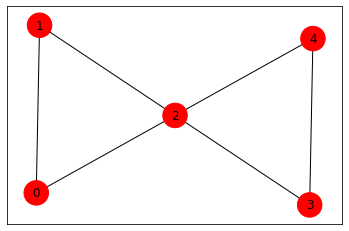

In [2]:
# Generating the butterfly graph with 5 nodes 
n = 5
V = np.arange(0,n,1)
E =[(0,1,1.0),(0,2,1.0),(1,2,1.0),(3,2,1.0),(3,4,1.0),(4,2,1.0)] 

G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

# Generate plot of the Graph
colors       = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G)

nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)

### 5.2 最適な試行状態のパラメーター <a id="implementation_sec52"></a>

この例において、$p = 1$ の場合、すなわちゲートのレイヤーのみの場合を考えます。期待値 $F_1(\gamma,\beta) = \langle \psi_1(\beta,\gamma)|H|\psi_1(\beta,\gamma) \rangle$ はこの簡単な設定で解析的に計算できます。ハミルトニアン $H = \sum_{(j,k) \in E} \frac{1}{2}\left(1 - Z_i Z_k\right)$ の手順を明示的に説明しましょう。期待値の線形性により、個々の枝に対する期待値を計算できます。


$$f_{(i,k)}(\beta,\alpha) =  \langle \psi_1(\gamma,\beta)|\;\frac{1}{2}\left(1 - Z_i Z_k\right)\;|\psi_1(\gamma,\beta)\rangle $$


上記のバタフライ・グラフにおいては、枝を $A = \{(0,1),(3,4)\}$ と $B = \{(0,2),(1,2),(2,3),(2,4)\}$ の2種類に分類できます。$A$ の枝は隣り合う枝を2つしか持たない一方、$B$の枝は4つ持っています。各セットで一本の枝の期待値を計算すると、同じセットの枝の期待値も同じであると納得できると思います。これは、二つの枝の期待値を計算するだけで、$F_1(\gamma,\beta) = 2 f_A(\gamma,\beta) + 4f_B(\gamma,\beta)$ を計算できることを意味します。[セクション4.2.2](#section_422)で概説されている議論に続き、パウリ演算子 $Z_0Z_1$ もしくは $Z_0Z_2$ と作用しないすべてのゲートが可換でキャンセルすることに注意すると、計算が必要なのは、


$$f_A(\gamma,\beta) = \frac{1}{2}\left(1 - \langle +^3|U_{21}(\gamma)U_{02}(\gamma)U_{01}(\gamma)X_{0}(\beta)X_{1}(\beta)\;Z_0Z_1\; X^\dagger_{1}(\beta)X^\dagger_{0}(\beta)U^\dagger_{01}(\gamma)U^\dagger_{02}(\gamma)U^\dagger_{12}(\gamma)  | +^3 \rangle \right)$$


と


$$f_B(\gamma,\beta) = \frac{1}{2}\left(1 - \langle +^5|U_{21}(\gamma)U_{24}(\gamma)U_{23}(\gamma)U_{01}(\gamma)U_{02}(\gamma)X_{0}(\beta)X_{2}(\beta)\;Z_0Z_2\; X^\dagger_{0}(\beta)X^\dagger_{2}(\beta)U^\dagger_{02}(\gamma)U^\dagger_{01}(\gamma)U^\dagger_{12}(\gamma)U^\dagger_{23}(\gamma)U^\dagger_{24}(\gamma)  | +^5 \rangle \right)$$


だけです。これらの期待値がどの程度複雑になるかは、一般的には、我々が考慮しているグラフの次数にのみ依存し、次数が制限されている場合には、グラフ全体の大きさには依存しません。この式の直接的な評価は、$U_{k,l}(\gamma) = \exp\left(-\frac{i\gamma}{2}(1 - Z_kZ_l)\right)$ と
$X_k(\beta) = \exp(-i\beta X_k)$ を用いて、


$$f_A(\gamma,\beta) = \frac{1}{2}+\frac{1}{4}\sin(2\gamma)\sin(4\beta) - \frac{1}{2}\sin^2(\gamma)\sin^2(2\beta)$$


と


$$f_B(\gamma,\beta) = \frac{1}{2}+\frac{3}{16}\sin(2\gamma)\sin(4\beta)+\frac{1}{32}\sin(4\gamma)\sin(4\beta) - \frac{1}{8}\sin^2(2\gamma)\sin^2(2\beta) $$


になります。これらの結果は上述の様に組み合わせると、すなわち、期待値は次の様に得られます。


$$ F_1(\gamma,\beta) = 3 - \frac{1}{2}\left(2\sin^2(\gamma) + \sin^2(2\gamma)\right)\sin^2(2\beta)+\frac{1}{8}\left(10\sin(2\gamma) + \sin(4\gamma) \right)\sin(4\beta), $$


関数 $F_1(\gamma,\beta)$ を描画し、簡単なグリッドサーチを使って期待値を最大化するパラメーター $(\gamma^*,\beta^*)$ を見つけましょう。

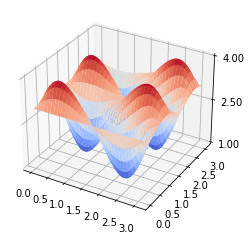


 --- OPTIMAL PARAMETERS --- 

The maximal expectation value is:  M1 = 3.927
This is attained for gamma = 0.600 and beta = 1.900


In [3]:
# Evaluate the function
step_size   = 0.1;

a_gamma         = np.arange(0, np.pi, step_size)
a_beta          = np.arange(0, np.pi, step_size)
a_gamma, a_beta = np.meshgrid(a_gamma,a_beta)

F1 = 3-(2*(np.sin(a_gamma))**2+np.sin(2*a_gamma)**2)*(np.sin(2*a_beta))**2/2+(10*np.sin(2*a_gamma)+np.sin(4*a_gamma))*np.sin(4*a_beta)/8

# Grid search for the maxmizing variables
result = np.where(F1 == np.amax(F1))
a      = list(zip(result[0],result[1]))[0]

gamma  = a[1]*step_size;
beta   = a[0]*step_size;

# Plot the expetation value F1
fig = plt.figure()
ax  = fig.add_subplot(111,projection='3d')

surf = ax.plot_surface(a_gamma, a_beta, F1, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax.set_zlim(1,4)
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

plt.show()

#The smallest parameters and the expectation can be extracted
print('\n --- OPTIMAL PARAMETERS --- \n')
print('The maximal expectation value is:  M1 = %.03f' % np.amax(F1))
print('This is attained for gamma = %.03f and beta = %.03f' % (gamma,beta))

### 5.3 量子回路<a id="implementation_sec53"></a>

これらのパラメーターを用いると、グラフの試行状態、すなわち上述した頂点 $V = \{0,1,2,3,4\}$ と枝 $E = \{(0,1),(0,2),(1,2),(3,2),(3,4),(4,2)\}$ を持つグラフ $G = (V,E)$ を準備する回路を作成できます。回路は $n = 5$ 量子ビットを必要とし、以下の状態を準備します。


$$ |\psi_1(\gamma ,\beta)\rangle = e^{ -i\beta B } e^{ -i\gamma H } |+\rangle^n.  $$


項が $B = \sum_{k \in V} X_k$ と $H = \sum_{(k,m) \in E} \frac{1}{2}\left(1 - Z_kZ_m\right)$ で与えられることを思い出してください。以下の手順で回路を生成します：

 - まず5つのアダマール・ゲート $H$ を実装し、均一な重ね合わせ状態を生成します。


 - 枝 $(k,l) \in E$ に 角度 $\gamma$のイジング・タイプ・ゲート $U_{k,l}(\gamma)$ を6つ作用させます。Qiskitに備わっているゲートを用いて以下のように表現することができます。


$$ U_{k,l}(\gamma) = CU1(2\gamma)_{k,l} U1(-\gamma)_k U1(-\gamma)_l$$


 - 各頂点 $k \in V$ に角度 $\beta$ の単一量子ビット $X$ 回転 $X_k(\beta)$ を作用させます。このゲートは、Qiskitで $X_k(\beta) = RX(2\beta)_k$ として直接パラメーター化されています。


 - 最後に、計算基底で量子ビットを測定します。すなわち、$Z$ 測定をして結果のビット文字列 $x \in \{0,1\}^5$ を記録します。

In [4]:
# prepare the quantum and classical resisters
QAOA = QuantumCircuit(len(V), len(V))

# apply the layer of Hadamard gates to all qubits
QAOA.h(range(len(V)))
QAOA.barrier()

# apply the Ising type gates with angle gamma along the edges in E
for edge in E:
    k = edge[0]
    l = edge[1]
    QAOA.cp(2*gamma, k, l)
    QAOA.p(-gamma, k)
    QAOA.p(-gamma, l)
    
# then apply the single qubit X - rotations with angle beta to all qubits
QAOA.barrier()
QAOA.rx(2*beta, range(len(V)))

# Finally measure the result in the computational basis
QAOA.barrier()
QAOA.measure(range(len(V)),range(len(V)))

### draw the circuit for comparison
QAOA.draw()

┌───┐ ░          ┌─────────┐         ┌─────────┐                    »
q_0: ┤ H ├─░──■───────┤ P(-0.6) ├─■───────┤ P(-0.6) ├────────────────────»
     ├───┤ ░  │P(1.2) ├─────────┤ │       └─────────┘         ┌─────────┐»
q_1: ┤ H ├─░──■───────┤ P(-0.6) ├─┼───────────────────■───────┤ P(-0.6) ├»
     ├───┤ ░          └─────────┘ │P(1.2) ┌─────────┐ │P(1.2) ├─────────┤»
q_2: ┤ H ├─░──────────────────────■───────┤ P(-0.6) ├─■───────┤ P(-0.6) ├»
     ├───┤ ░                              └─────────┘         └─────────┘»
q_3: ┤ H ├─░─────────────────────────────────────────────────────────────»
     ├───┤ ░                                                             »
q_4: ┤ H ├─░─────────────────────────────────────────────────────────────»
     └───┘ ░                                                             »
c: 5/════════════════════════════════════════════════════════════════════»
                                                                         »
«                                                                  ░ »
«q_0: ─────────────────────────────────────────────────────────────░─»
«                                                                  ░ »
«q_1: ─────────────────────────────────────────────────────────────░─»
«              ┌─────────┐                             ┌─────────┐ ░ »
«q_2: ─■───────┤ P(-0.6) ├─────────────────────■───────┤ P(-0.6) ├─░─»
«      │P(1.2) ├─────────┤         ┌─────────┐ │       └─────────┘ ░ »
«q_3: ─■───────┤ P(-0.6) ├─■───────┤ P(-0.6) ├─┼───────────────────░─»
«              └─────────┘ │P(1.2) ├─────────┤ │P(1.2) ┌─────────┐ ░ »
«q_4: ─────────────────────■───────┤ P(-0.6) ├─■───────┤ P(-0.6) ├─░─»
«                                  └─────────┘         └─────────┘ ░ »
«c: 5/═══════════════════════════════════════════════════════════════»
«                                                                    »
«     ┌─────────┐ ░ ┌─┐            
«q_0: ┤ Rx(3.8) ├─░─┤M├────────────
«     ├─────────┤ ░ └╥┘┌─┐         
«q_1: ┤ Rx(3.8) ├─░──╫─┤M├─────────
«     ├─────────┤ ░  ║ └╥┘┌─┐      
«q_2: ┤ Rx(3.8) ├─░──╫──╫─┤M├──────
«     ├─────────┤ ░  ║  ║ └╥┘┌─┐   
«q_3: ┤ Rx(3.8) ├─░──╫──╫──╫─┤M├───
«     ├─────────┤ ░  ║  ║  ║ └╥┘┌─┐
«q_4: ┤ Rx(3.8) ├─░──╫──╫──╫──╫─┤M├
«     └─────────┘ ░  ║  ║  ║  ║ └╥┘
«c: 5/═══════════════╩══╩══╩══╩══╩═
«                    0  1  2  3  4

### 5.4  コスト関数の評価<a id="implementation_sec54"></a>

最後にビット文字列からコスト関数値を計算するルーチンが必要です。
これは"良い候補"のビット文字列 $x$ を見つけたかどうか判断するのに必要なだけでなく、期待値を直接評価できない場合に $F_1(\gamma,\beta)$ の期待値を推定することにも使用されます。

In [5]:
# Compute the value of the cost function
def cost_function_C(x,G):
    
    E = G.edges()
    if( len(x) != len(G.nodes())):
        return np.nan
        
    C = 0;
    for index in E:
        e1 = index[0]
        e2 = index[1]
        
        w      = G[e1][e2]['weight']
        C = C + w*x[e1]*(1-x[e2]) + w*x[e2]*(1-x[e1])
        
    return C

## 5a. QAOAをシミュレーターで動かす<a id="implementationsim"></a>

まず、このアルゴリズムをローカルのQASMシミュレーターで実行します。

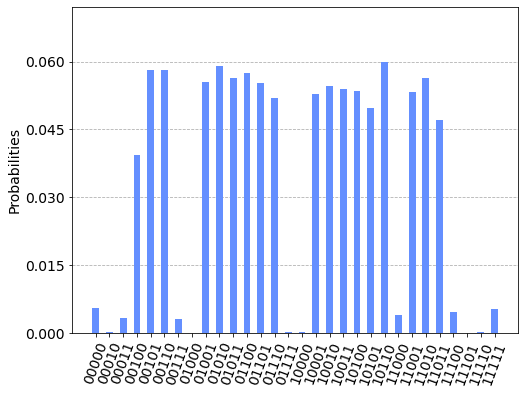

In [6]:
# run on local simulator
backend = Aer.get_backend("aer_simulator")
shots = 10000

TQAOA = transpile(QAOA, backend)
qobj = assemble(TQAOA, shots=shots)
QAOA_results = backend.run(qobj).result()

plot_histogram(QAOA_results.get_counts(),figsize = (8,6),bar_labels = False)

#### シミュレーションのデータを評価する

シミュレーションのデータから関連する情報を計算していきましょう。得られた結果を以下の様に使用します。

- 平均エネルギーを計算し、理論的予想に合致しているか調べます
- 得られたビット文字列のサンプルの中からコスト関数値 $C(x^*)$ が最大になったビット文字列 $x^*$ を報告します
- エネルギーのヒストグラムを描画し、予想した平均の回りに本当に集中しているか確認します


 --- SIMULATION RESULTS ---

The sampled mean value is M1_sampled = 3.92 while the true value is M1 = 3.93 

The approximate solution is x* = 10100 with C(x*) = 4 

The cost function is distributed as: 



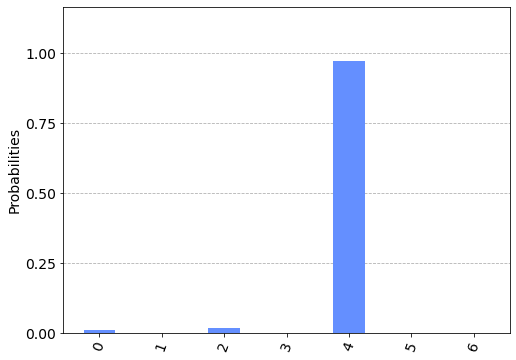

In [7]:
# Evaluate the data from the simulator
counts = QAOA_results.get_counts()

avr_C       = 0
max_C       = [0,0]
hist        = {}

for k in range(len(G.edges())+1):
    hist[str(k)] = hist.get(str(k),0)

for sample in list(counts.keys()):

    # use sampled bit string x to compute C(x)
    x         = [int(num) for num in list(sample)]
    tmp_eng   = cost_function_C(x,G)
    
    # compute the expectation value and energy distribution
    avr_C     = avr_C    + counts[sample]*tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
    
    # save best bit string
    if( max_C[1] < tmp_eng):
        max_C[0] = sample
        max_C[1] = tmp_eng
                
M1_sampled   = avr_C/shots

print('\n --- SIMULATION RESULTS ---\n')
print('The sampled mean value is M1_sampled = %.02f while the true value is M1 = %.02f \n' % (M1_sampled,np.amax(F1)))
print('The approximate solution is x* = %s with C(x*) = %d \n' % (max_C[0],max_C[1]))
print('The cost function is distributed as: \n')
plot_histogram(hist,figsize = (8,6),bar_labels = False)

## 5b. QAOAを量子デバイスの実機で動かす<a id="implementationdev"></a>

次に、実機のバックエンドで同じ回路がどの様に実行されるか見ましょう。

In [9]:
# Use the IBMQ essex device
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_bogota')
shots = 2048

TQAOA = transpile(QAOA, backend)
job_exp = backend.run(TQAOA, shots=shots)
job_monitor(job_exp)

ibmqfactory.load_account:WARNING:2022-07-05 20:21:29,647: Credentials are already in use. The existing account in the session will be replaced.


QiskitBackendNotFoundError: 'No backend matches the criteria'

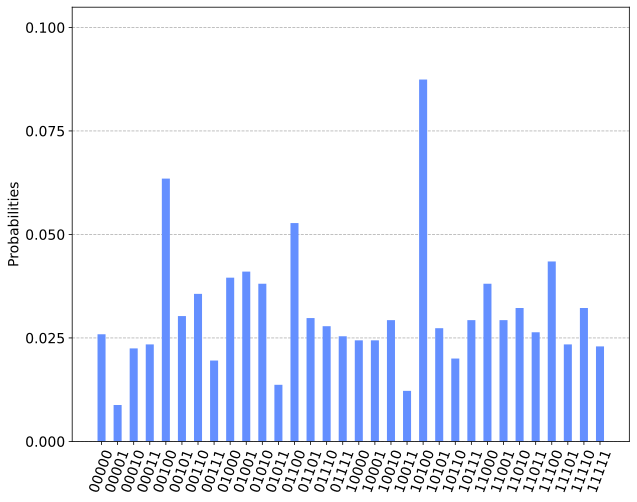

In [9]:
exp_results = job_exp.result()
plot_histogram(exp_results.get_counts(),figsize = (10,8),bar_labels = False)

#### 実験データを評価する

前と同じ分析を繰り返して、実験結果を比較します。


 --- EXPERIMENTAL RESULTS ---

The sampled mean value is M1_sampled = 3.14 while the true value is M1 = 3.43 

The approximate solution is x* = 00101 with C(x*) = 4 

The cost function is distributed as: 



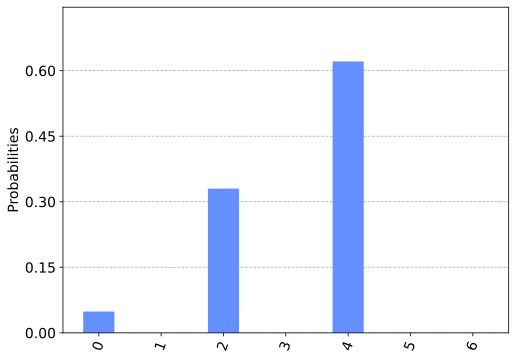

In [10]:
# Evaluate the data from the experiment
counts = exp_results.get_counts()

avr_C       = 0
max_C       = [0,0]
hist        = {}

for k in range(len(G.edges())+1):
    hist[str(k)] = hist.get(str(k),0)

for sample in list(counts.keys()):

    # use sampled bit string x to compute C(x)
    x         = [int(num) for num in list(sample)]
    tmp_eng   = cost_function_C(x,G)
    
    # compute the expectation value and energy distribution
    avr_C     = avr_C    + counts[sample]*tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
    
    # save best bit string
    if( max_C[1] < tmp_eng):
        max_C[0] = sample
        max_C[1] = tmp_eng
                
M1_sampled   = avr_C/shots

print('\n --- EXPERIMENTAL RESULTS ---\n')
print('The sampled mean value is M1_sampled = %.02f while the true value is M1 = %.02f \n' % (M1_sampled,np.amax(F1)))
print('The approximate solution is x* = %s with C(x*) = %d \n' % (max_C[0],max_C[1]))
print('The cost function is distributed as: \n')
plot_histogram(hist,figsize = (8,6),bar_labels = False)

## 6. 演習問題<a id="problems"></a>

1. QAOAはビット文字列を生成しますが、この文字列はそのグラフにとって最適解でしょうか？実機上の実験結果とローカルQASMシミュレーターの結果を比較してください。


2. [セクション 5.2](#implementation_sec52) で、コスト関数 $F_1$ を解析的に計算しました。ステップを検証し、$f_A(\gamma,\beta)$ ならびに $f_B(\gamma,\beta)$ を計算してください。


3. Qiskitでの実装において $F_1$ の正確な式が与えられました。 

      - 結果で得られたサンプルから期待値 $F_1(\gamma,\beta)$ を推定するルーチンを作成してください (ヒント: [セクション 5.4](#implementation_sec54) での cost_function_C(x,G)関数 と [セクション 5.a / 5.b](#implementationsim)のデータの評価を使用します)。
       
      - 最適化ルーチン、例えばこのチュートリアルのVQEの例のSPSAなどを使って、サンプリングされた$F_1(\gamma,\beta)$ のパラメーターを数値的に最適化してください。$\gamma^*$ と $\beta^*$ に対し同じ値を見つけましたか？


4. [セクション 5.3](#implementation_sec53)の試行回路は、深さ $p=1$ で、ハードウェアと互換性があるよう意図したものでした。

    - 問題2のルーチンを使って、$p=2,3$ に対しコスト関数 $F_p(\gamma,\beta)$ を評価してください。実機上での実行でどうなると思いますか?
    
    - 参考文献 [4](#references) のハードウェアに特化した試行状態を参考にして、この節で取り上げた試行状態のクラスを他の波動関数に一般化してください。


5. 様々な例のセクションで説明した MAX-3-SAT の例を考え、それに応じて $F_p$ を計算するために使用した [セクション 5.4](#implementation_sec54) の cost_function_C(x,G) 関数を修正してください。ハードウェアに特化したアルゴリズムを使用して、この MAX-3-SAT のインスタンスに対してQAOAを実行し、その結果を分析してください。 

## 7. 参考文献<a id="references"></a>

1. Garey, Michael R.; David S. Johnson (1979). Computers and Intractability: A Guide to the Theory of NP-Completeness. W. H. Freeman. ISBN 0-7167-1045-5
2. Goemans, Michel X., and David P. Williamson. [Journal of the ACM (JACM) 42.6 (1995): 1115-1145](http://www-math.mit.edu/~goemans/PAPERS/maxcut-jacm.pdf).
3. Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint [arXiv:1411.4028 (2014)](https://arxiv.org/abs/1411.4028).
4. Kandala, Abhinav, et al. "Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets." [Nature 549.7671 (2017): 242](https://www.nature.com/articles/nature23879).
5. Farhi, Edward, et al. "Quantum algorithms for fixed qubit architectures." arXiv preprint [arXiv:1703.06199 (2017)](https://arxiv.org/abs/1703.06199).
6. Spall, J. C. (1992), [IEEE Transactions on Automatic Control, vol. 37(3), pp. 332–341](https://ieeexplore.ieee.org/document/119632).
7. Michael Streif and Martin Leib "Training the quantum approximate optimization algorithm without access to a quantum processing unit" (2020) [Quantum Sci. Technol. 5 034008](https://doi.org/10.1088/2058-9565/ab8c2b)

In [11]:
import qiskit.tools.jupyter
%qiskit_version_table

{'qiskit-terra': '0.14.2',
 'qiskit-aer': '0.5.2',
 'qiskit-ignis': '0.3.3',
 'qiskit-ibmq-provider': '0.7.2',
 'qiskit-aqua': '0.7.3',
 'qiskit': '0.19.6'}